# Data loading
**Importing modules**

---



In [14]:
# Modules to import the data set from Github
import os
import zipfile
import random
import pickle

import pandas as pd
import numpy as np
from tqdm import tqdm

# Modules for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Modules for performance metrics
from sklearn.metrics import (
    f1_score, roc_auc_score, confusion_matrix, accuracy_score,
    precision_recall_curve, auc, make_scorer
)

# Modules for feature transformation, scaling, and splitting data
from sklearn.decomposition import PCA
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
)
from sklearn.preprocessing import MinMaxScaler

# Modules for classifiers
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from scipy.stats import loguniform, uniform

# Supress warnings
from warnings import filterwarnings
filterwarnings('ignore', category=UserWarning)


**Initializing Functions**


---


Below, functions are defined that will be used further down in the code

In [10]:
def pr_auc_score(y_true, y_pred_proba):
    """
    Calculate AUC of precision recall curve from classifier prediction
    """
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    return auc(recall, precision)

**Data Loading**


---


Below are functions to load the ECG dataset that contains frequency features of both normal and abnormal ECG's.

In [11]:
# Run this to use from colab environment
!git clone https://github.com/jveenland/tm10007_ml.git

with zipfile.ZipFile('/content/tm10007_ml/ecg/ecg_data.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/tm10007_ml/ecg')

data = pd.read_csv('/content/tm10007_ml/ecg/ecg_data.csv', index_col=0)

fatal: destination path 'tm10007_ml' already exists and is not an empty directory.


**Describtion of the dataset**


---

Before we can train classifiers, it is important to understand the data we will be working with. Therefore we give a short description of our dataset.

From this, we learn that:


*   The number of features in the dataset is a lot larger that the number of samples (curse of dimensionality).
*   There are no further actions required regarding missing values.
*   The number of normal ECGs in the dataset is a lot larger than the number of abnormal ECGs (imbalanced dataset).
*   The dataset contains many outliers, so scaling is required.
*   The features do not all follow a normal distribution.



The dataset contains 827 samples and 9000 features.
The dataset contains 0 missing values.
The dataset contains 681 normal ECGs, and  146 abnormal ECGs.


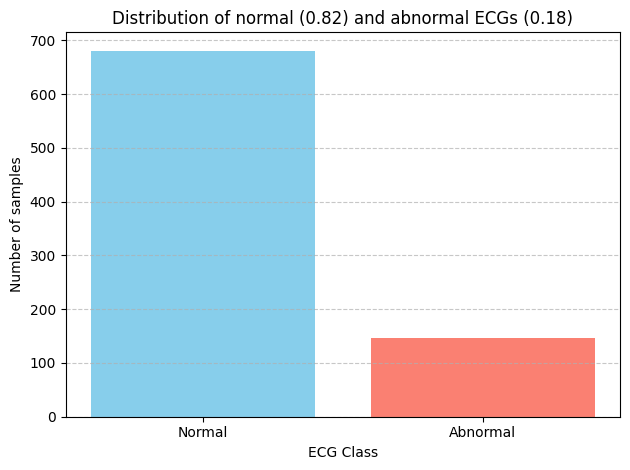

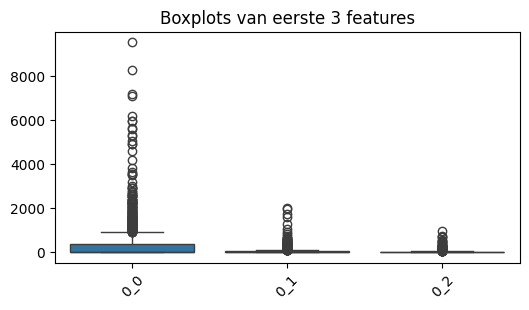

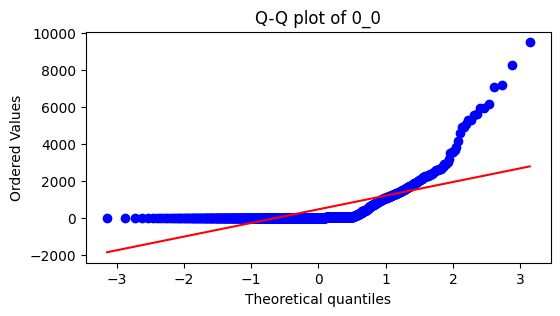

In [7]:
# Samples and features
print(f'The dataset contains {len(data.index)} samples and {len(data.columns)-1} features.')

# Check for missing features
missing_total = data.isnull().sum().sum() #sum of NaNs
print (f'The dataset contains {(missing_total)} missing values.')

# Splitting features and labels
x = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

# Check imbalance of the dataset
normal_count = (y == 0).sum()
abnormal_count = (y == 1).sum()
print("The dataset contains",normal_count, "normal ECGs, and ", abnormal_count, "abnormal ECGs.")

total_class = normal_count + abnormal_count
normal_ratio = normal_count / total_class
abnormal_ratio = abnormal_count / total_class

# Plot with correct title formatting
plt.bar(['Normal', 'Abnormal'], [normal_count, abnormal_count], color=['skyblue', 'salmon'])
plt.xlabel('ECG Class')
plt.ylabel('Number of samples')
plt.title(f'Distribution of normal ({normal_ratio:.2f}) and abnormal ECGs ({abnormal_ratio:.2f})')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot boxplots van de features
features = data.columns[:-1][:3]
plt.figure(figsize=(6, 3))
sns.boxplot(data=data[features])
plt.title("Boxplots van eerste 3 features")
plt.xticks(rotation=45)
plt.show()

# Q-Q plot for one feature
feature = data.columns[0]
plt.figure(figsize=(6, 3))
stats.probplot(data[feature], dist="norm", plot=plt)
plt.title(f"Q-Q plot of {feature}")
plt.show()

# Initializing variables

Here all variables to save the data are initialized

***Note that:***


```
outer = range(2) # Usually set to a much higher value so that the code runs overnight
```

*Due to the way the code is set up to save the test results per outerloop, the code can be stopped at any time. Thus range is usually set to >500 to exceed a runtime of 8 hours. The code is started before going to bed and stopped once we wake up. To make the code runnable in a reasonable timespan for demonstration purposes, the outer range is set way lower than usual.*

***Further note that:***

```
n_RF = 5 # Usually set at 100
```

*n_randomsearchcv is the amount of times the RandomizedSearchCV model runs per outer iteration. To make the code runnable in a reasonable timespan for demonstration purposes, n_RF is set way lower than usual.*

In [17]:
# outer loop range
outer = range(2) # Usually set to a much higher value so that the code runs overnight
n_randomsearchcv = 5 # Usually set at 100

# Initializes parameter and model dicts
best_params_dict_KNN = {}
best_model_dict_KNN = {}

best_params_dict_RF = {}
best_model_dict_RF = {}

best_params_dict_SVM = {}
best_model_dict_SVM = {}

# Initialize variables to store precision-recall data
precision_list_KNN = []
recall_list_KNN = []
auc_list_KNN = []

precision_list_RF = []
recall_list_RF = []
auc_list_RF = []

precision_list_SVM = []
recall_list_SVM = []
auc_list_SVM = []


# k-Nearest Neighbor classifier - Training

---
***We use the same pipeline for three different classifiers that we built. As a result, we will explain the first classifier (the kNN classifier) in detail, and the other follow the same structure.

---

**Nested structure**

A nested structure will be used for hyperparameter tuning. With outer and inner loops. The outer folds we're determined by the outer loop (the tdqm progressbar library is used to track the progress of this loop). The inner loop is determined by the cross validation structure in either the RandomSearchCV or in the K-NN's case in the GridSearchCV.

**Creating a split in the data**

The dataset was split into a **training** and a **test** set to evaluate model performance reliably.

**Outerfold - Initial Split:**

First, 80% of the data was allocated to training and 20% to testing using *train_test_split()*. The number of the outerfold was also the random state, to ensure a different but reproducible split for each fold.

**Innerfold -Secondary Split:**

The training set was further split with a crossvalidation structure, using a StratifiedKfold with 7 folds, i.e. a train:test ratio of 85,7%:14.3% to create validation data. This helped reduce bias and improved the generalizability of the models.

These steps allowed for thorough model evaluation, while keeping the test set untouched until the final stage, ensuring an unbiased assessment.



*We use **stratified** splits so the proportions of normal and abnormal ECGs remains consistent across the training and test set, so that the model is evaluated on a representative sample of the data. Furthermore, aside from the the outerfold *train_test_split()*, a **random state** 7 was used to ensure the reproducibility of the plots presented in our report.*

---

**Defining parameters**

A parameter grid was predetermined for the K-NN classifier. For the CVM and RF the grid was randomized between realistic parameter bounds.

---

**Pipeline**

A pipeline is used to ensure all preprocessing steps are done in order. Preprocessing is done after the train-test split, to ensure the test data is left untouched. Ideally, this would also done after the training data is devided between train and validation, but due to a lack of computational power (since this would take much longer) this compromise was taken.

**Scaling**

As vizualized above, the data contain outliers which could affect the way your model is trained. However, through trial and error, we found that these outliers improve the way the model makes predicitions. Therefore, **MinMax** scaling is applied, as this enhanced the outliers in the data.

**Feature transformation**

The dataset contains far more features than samples, which increases the risks over overfitting your model and makes computation more complex. Therefore **Principal Component Anlysis** (PCA) is applied on the data to reduce the dimensions.


**StratifiedKFold**

As previously mentioned, the StratifiedKFold was used to split the data in 7 folds and served as the inner cross validation folds.

---

**Auc score function**

To properly asses search, we use a function to calculate the PR AUC as scorring metric. This function is initialized right after the imports in the code:

```
def pr_auc_score(y_true, y_pred_proba):
      precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
      return auc(recall, precision)
```

---

**Training**

Here the K-NN model is trained with hyperparameter optimalization using GridSearchCV. With the pr_auc as scoring metric. The best model is saved in a dicitonary. Also the parameters are saved in a dict.

---

**Compute Scores**

We compute all the following scores for each model:
- ROC AUC
- F1
- Sensitivity
- Specificity
- Accuracy
- Precision recall curve
- PR AUC

---

**Saving the hyperparameter training data**

We save the first five scores as a .csv file, including the hyperparameters of the model. The precision recall curve and PR AUC are saved as a pickle file.

This saving occurs each outerloop. This ensures that the script can be closed at any time without the loss of data.

---


In [12]:
for outer_rand in tqdm(outer, desc='Outer Loop'):
    # Split data into outer folds
    X_train_outer, X_test_outer, y_train_outer, y_test_outer = train_test_split(
            x, y, test_size=0.2, stratify=y, shuffle=True, random_state=outer_rand)

    # Scale features using MinMaxScaler
    scaler = MinMaxScaler(feature_range=(0, 1))
    X_train_outer = scaler.fit_transform(X_train_outer)
    X_test_outer = scaler.transform(X_test_outer)

    # Apply PCA
    pca = PCA(n_components=0.95)  # Keep 95% variance
    X_train_outer = pca.fit_transform(X_train_outer)
    X_test_outer = pca.transform(X_test_outer)

    # Create a pipeline with scaling, PCA, and KNeighborsClassifier
    param_grid_knn = {
        'knn__n_neighbors': list(range(3, 25)),  # Iterate over k from 3 to 24
        'knn__weights': ['uniform', 'distance'],
        'knn__metric': ['euclidean', 'manhattan'],
        'knn__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    }

    pipeline = Pipeline([
        ('knn', KNeighborsClassifier())
    ])

    # For classification problems to maintain class distribution
    cv_inner = StratifiedKFold(n_splits=7, shuffle=True, random_state=42)

    pr_auc_scorer = make_scorer(pr_auc_score, y_score = True)

    random_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid_knn,
        scoring=pr_auc_scorer,
        cv=cv_inner,
        n_jobs=-1
    )

    random_search.fit(X_train_outer, y_train_outer)

    best_params = random_search.best_params_
    best_params_dict_KNN[f"Outer {outer_rand}"] = best_params
    best_model_dict_KNN[f"Outer {outer_rand}"] = random_search.best_estimator_


    y_pred = best_model_dict_KNN[f"Outer {outer_rand}"].predict(X_test_outer)
    tn, fp, fn, tp = confusion_matrix(y_test_outer, y_pred).ravel()

    # Calculate metrics
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    y_pred_proba = best_model_dict_KNN[f"Outer {outer_rand}"].predict_proba(X_test_outer)[:, 1]
    auc_score = roc_auc_score(y_test_outer, y_pred_proba)
    f1 = f1_score(y_test_outer, y_pred)
    accuracy = accuracy_score(y_test_outer, y_pred)

    # precision recall curve
    precision, recall, _ = precision_recall_curve(y_test_outer, y_pred_proba)
    precision_list_KNN.append(precision)
    recall_list_KNN.append(recall)
    auc_list_KNN.append(auc(recall, precision))

    best_params_dict_KNN[f"Outer {outer_rand}"]['auc'] = auc_score
    best_params_dict_KNN[f"Outer {outer_rand}"]['f1'] = f1
    best_params_dict_KNN[f"Outer {outer_rand}"]['sensitivity'] = sensitivity
    best_params_dict_KNN[f"Outer {outer_rand}"]['specificity'] = specificity
    best_params_dict_KNN[f"Outer {outer_rand}"]['accuracy'] = accuracy


    print(f"\nOuter {outer_rand} -> Best Hyperparameters: {best_params}")

    # Save results
    results_df = pd.DataFrame.from_dict(best_params_dict_KNN, orient='index')
    results_csv_path = os.path.join(os.getcwd(), 'KNN_best_hyperparameters.csv')
    results_df.to_csv(results_csv_path)
    print(f"\nBest parameters saved to {results_csv_path} after Outer {outer_rand} completion")

    # Save precision-recall data
    pr_data = {
        "precision_list": precision_list_KNN,
        "recall_list": recall_list_KNN,
        "auc_list": auc_list_KNN
    }
    pr_data_path = os.path.join(os.getcwd(), 'KNN_precision_recall_data.pkl')
    with open(pr_data_path, 'wb') as f:
        pickle.dump(pr_data, f)
    print(f"\nPrecision-recall data saved to {pr_data_path} after Outer {outer_rand} completion")


Outer Loop:  50%|█████     | 1/2 [00:51<00:51, 51.90s/it]


Outer 0 -> Best Hyperparameters: {'knn__algorithm': 'auto', 'knn__metric': 'euclidean', 'knn__n_neighbors': 3, 'knn__weights': 'uniform', 'auc': 0.61213189025925, 'f1': 0.16216216216216217, 'sensitivity': 0.10344827586206896, 'specificity': 0.9635036496350365, 'accuracy': 0.8132530120481928}

Best parameters saved to /content/best_hyperparameters_short.csv after Outer 0 completion

Precision-recall data saved to /content/precision_recall_data.pkl after Outer 0 completion


Outer Loop: 100%|██████████| 2/2 [01:59<00:00, 59.63s/it]


Outer 1 -> Best Hyperparameters: {'knn__algorithm': 'auto', 'knn__metric': 'euclidean', 'knn__n_neighbors': 3, 'knn__weights': 'uniform', 'auc': 0.6706519003272086, 'f1': 0.17647058823529413, 'sensitivity': 0.10344827586206896, 'specificity': 0.9854014598540146, 'accuracy': 0.8313253012048193}

Best parameters saved to /content/best_hyperparameters_short.csv after Outer 1 completion

Precision-recall data saved to /content/precision_recall_data.pkl after Outer 1 completion


# Random Forest Classifier - Training

The difference from the k-NN classifier is only the hyperparameters that are evaluated and the usage of RandomizedSearchCV instead of GridSearchCV

---

In [16]:
for outer_rand in tqdm(outer, desc='Outer Loop'):
    # Split data into outer folds
    X_train_outer, X_test_outer, y_train_outer, y_test_outer = train_test_split(
            x, y, test_size=0.2, stratify=y, shuffle=True, random_state=outer_rand)

    # Apply MinMaxScaler and PCA to the data before passing it to the pipeline
    scaler = MinMaxScaler(feature_range=(0, 1))
    X_train_outer = scaler.fit_transform(X_train_outer)
    X_test_outer = scaler.transform(X_test_outer)

    pca = PCA(n_components=0.99)  # Retain 99% of variance
    x_train_outer = pca.fit_transform(X_train_outer)
    x_test_outer = pca.transform(X_test_outer)

    # Hyperparameter grid
    param_grid_rf = {
        'n_estimators': [random.randint(5, 75) for _ in range(50)],
        'max_depth': [random.randint(1, 10) for _ in range(50)],
        'min_samples_split': [random.randint(2, 5) for _ in range(50)],
        'min_samples_leaf': [random.randint(1, 4) for _ in range(50)],
        'max_samples': [random.uniform(0.5, 1) for _ in range(50)],
        'bootstrap': [True]
    }
    # Create a pipeline with scaling, PCA, and RandomForestClassifier
    rf = RandomForestClassifier(random_state=7, n_jobs=-1)

    # For classification problems to maintain class distribution for 14.3% splits
    cv_inner = StratifiedKFold(n_splits=7, shuffle=True, random_state=7)

    random_search = RandomizedSearchCV(
        estimator=rf,
        param_distributions=param_grid_rf,
        scoring='roc_auc',
        cv=cv_inner,
        n_iter=n_randomsearchcv,
        n_jobs=-1,
        random_state=7
    )

    random_search.fit(X_train_outer, y_train_outer)

    best_params = random_search.best_params_
    best_params_dict_RF[f"Outer {outer_rand}"] = best_params
    best_model_dict_RF[f"Outer {outer_rand}"] = random_search.best_estimator_
    y_pred = best_model_dict_RF[f"Outer {outer_rand}"].predict(X_test_outer)
    tn, fp, fn, tp = confusion_matrix(y_test_outer, y_pred).ravel()

    # Calculate metrics
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    y_pred_proba = best_model_dict_RF[f"Outer {outer_rand}"].predict_proba(X_test_outer)[:, 1]
    auc_score = roc_auc_score(y_test_outer, y_pred_proba)
    f1 = f1_score(y_test_outer, y_pred)
    accuracy = accuracy_score(y_test_outer, y_pred)

    # precision recall curve
    precision, recall, _ = precision_recall_curve(y_test_outer, y_pred_proba)
    precision_list_RF.append(precision)
    recall_list_RF.append(recall)
    auc_list_RF.append(auc(recall, precision))

    best_params_dict_RF[f"Outer {outer_rand}"]['auc'] = auc_score
    best_params_dict_RF[f"Outer {outer_rand}"]['f1'] = f1
    best_params_dict_RF[f"Outer {outer_rand}"]['sensitivity'] = sensitivity
    best_params_dict_RF[f"Outer {outer_rand}"]['specificity'] = specificity
    best_params_dict_RF[f"Outer {outer_rand}"]['accuracy'] = accuracy


    print(f"\nOuter {outer_rand} -> Best Hyperparameters: {best_params}")

    # Save results
    results_df = pd.DataFrame.from_dict(best_params_dict_RF, orient='index')
    results_csv_path = os.path.join(os.getcwd(), 'RF_best_hyperparameters.csv')
    results_df.to_csv(results_csv_path)
    print(f"\nBest parameters saved to {results_csv_path} after Outer {outer_rand} completion")

    # Save precision-recall data
    pr_data = {
        "precision_list": precision_list_RF,
        "recall_list": recall_list_RF,
        "auc_list": auc_list_RF
    }
    pr_data_path = os.path.join(os.getcwd(), 'RF_precision_recall_data.pkl')
    with open(pr_data_path, 'wb') as f:
        pickle.dump(pr_data, f)
    print(f"\nPrecision-recall data saved to {pr_data_path} after Outer {outer_rand} completion")



Outer Loop:  50%|█████     | 1/2 [01:29<01:29, 89.15s/it]


Outer 0 -> Best Hyperparameters: {'n_estimators': 95, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_samples': 0.6905638763418286, 'max_depth': 28, 'bootstrap': True, 'auc': 0.6877674301535364, 'f1': 0.17647058823529413, 'sensitivity': 0.10344827586206896, 'specificity': 0.9854014598540146, 'accuracy': 0.8313253012048193}

Best parameters saved to /content/RF_best_hyperparameters.csv after Outer 0 completion

Precision-recall data saved to /content/RF_precision_recall_data.pkl after Outer 0 completion


Outer Loop: 100%|██████████| 2/2 [02:45<00:00, 82.81s/it]


Outer 1 -> Best Hyperparameters: {'n_estimators': 153, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_samples': 0.7006280379556052, 'max_depth': 16, 'bootstrap': True, 'auc': 0.8024163100931286, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to /content/RF_best_hyperparameters.csv after Outer 1 completion

Precision-recall data saved to /content/RF_precision_recall_data.pkl after Outer 1 completion


# Support Vector Machine - Training

The difference from the k-NN classifier is only the hyperparameters that are evaluated and the usage of RandomizedSearchCV instead of GridSearchCV

---


In [ ]:
for outer_rand in tqdm(outer, desc='Outer Loop'):
    X_train_outer, X_test_outer, y_train_outer, y_test_outer = train_test_split(
        x, y, test_size=0.2, stratify=y, shuffle=True, random_state=outer_rand
    )

    # Apply MinMaxScaler and PCA separately to the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    X_train_outer = scaler.fit_transform(X_train_outer)
    X_test_outer = scaler.transform(X_test_outer)

    pca = PCA(n_components=0.99, random_state=7)
    X_train_outer = pca.fit_transform(X_train_outer)
    X_test_outer = pca.transform(X_test_outer)

    # Define pipeline
    pipeline = Pipeline([
        ('svc', SVC(kernel='rbf', probability=True))
    ])

    # Hyperparameter space for RandomizedSearchCV
    param_grid_svc = {
        'svc__C': loguniform(0.01, 1000),
        'svc__gamma': loguniform(0.0001, 100),
        'svc__class_weight': ['balanced', None],
        'svc__shrinking': [True, False],
        'svc__tol': uniform(1e-5, 1e-2)
    }

    cv_inner = StratifiedKFold(n_splits=7, shuffle=True, random_state=7)

    pr_auc_scorer = make_scorer(pr_auc_score, needs_proba=True)

    random_search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_grid_svc,
        scoring=pr_auc_scorer,
        cv=cv_inner,
        n_iter=n_randomsearchcv,
        n_jobs=-1,
        random_state=7
    )

    random_search.fit(X_train_outer, y_train_outer)

    best_model = random_search.best_estimator_
    best_params = random_search.best_params_

    y_pred = best_model.predict(X_test_outer)
    y_pred_proba = best_model.predict_proba(X_test_outer)[:, 1]

    tn, fp, fn, tp = confusion_matrix(y_test_outer, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    auc_score = roc_auc_score(y_test_outer, y_pred_proba)
    f1 = f1_score(y_test_outer, y_pred)
    accuracy = accuracy_score(y_test_outer, y_pred)

    precision, recall, _ = precision_recall_curve(y_test_outer, y_pred_proba)
    pr_score = auc(recall, precision)

    best_params_dict_SVM[f"Outer {outer_rand}"] = {
        **best_params,
        'auc': auc_score,
        'f1': f1,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'accuracy': accuracy,
        'pr_auc': pr_score
    }
    best_model_dict_SVM[f"Outer {outer_rand}"] = best_model

    precision_list_SVM.append(precision)
    recall_list_SVM.append(recall)
    auc_list_SVM.append(pr_score)

    # Save best parameters
    results_df = pd.DataFrame.from_dict(best_params_dict, orient='index')
    results_csv_path = os.path.join(os.getcwd(), 'SVM_best_hyperparameters.csv')
    results_df.to_csv(results_csv_path)

    # Save PR curve data
    pr_data = {
        "precision_list": precision_list_SVM,
        "recall_list": recall_list_SVM,
        "auc_list": auc_list_SVM
    }
    pr_data_path = os.path.join(os.getcwd(), 'SVM_precision_recall_data.pkl')
    with open(pr_data_path, 'wb') as f:
        pickle.dump(pr_data, f)

# Linear Classifier - Training

We expect the linear classifier to perform poorly, as the data is expected to be non-linearly and not normally distributed. Nevertheless, we still train the linear classifier to confirm this expextation and demonstrate that accuracy alone is not a valid performance metric.

---





In [ ]:
# Splitting the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
# Scaling the features
scaler = MinMaxScaler(feature_range=(0, 1))
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
# Applying PCA
pca = PCA(n_components=0.99)
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)
# Creating and training the linear classifier
classifier = LogisticRegression()
classifier.fit(x_train, y_train)

# Making predictions
y_pred = classifier.predict(x_test)

# Evaluating the classifier
accuracy = accuracy_score(y_test, y_pred)
# Calculate F1 score
f1 = f1_score(y_test, y_pred)

# Calculate sensitivity and specificity
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# Calculate AUC
auc = roc_auc_score(y_test, classifier.predict_proba(x_test)[:, 1])

# Print the metrics
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")
print(f"AUC: {auc}")

# k-Nearest Neighbor Classifier - Model


---



In [ ]:
#prior split
X_train, X_test, y_train, y_test = train_test_split(
        x, y, test_size=0.2, stratify=y, shuffle=True, random_state=7)

parameters = {
    'algorithm': 'auto',
    'metric': 'euclidean',
    'n_neighbors': 24,
    'weights': 'uniform',
}

pipeline = Pipeline([
    ('minmaxscaler', MinMaxScaler(feature_range=(0, 1))),
    ('pca', PCA(n_components=0.99)),
    ('rfc', KNeighborsClassifier(**parameters, n_jobs=-1))
])

pipeline.fit(X_test, y_test)

# Generate learning curve data
train_sizes, train_scores, test_scores = learning_curve(
    pipeline, X_train, y_train, cv=StratifiedKFold(n_splits=7), scoring='roc_auc', n_jobs=-1)

# Calculate mean and standard deviation for training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure()
plt.title("Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.grid()

# Plot the mean and standard deviation for training and test scores
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.ylim(0.3, 1.05)
plt.legend(loc="best")
plt.show()

# Random Forest Classifier - Model


---



In [ ]:
#prior split
X_train, X_test, y_train, y_test = train_test_split(
        x, y, test_size=0.2, stratify=y, shuffle=True, random_state=7)

parameters = {
    'n_estimators': 69,
    'min_samples_split': 3,
    'min_samples_leaf': 1,
    'max_samples': 0.500144539240563,
    'max_depth': 16,
    'bootstrap': True
}

pipeline = Pipeline([
    ('minmaxscaler', MinMaxScaler(feature_range=(0, 1))),
    ('pca', PCA(n_components=0.99)),
    ('rfc', RandomForestClassifier(**parameters, n_jobs=-1))
])

pipeline.fit(X_test, y_test)

# Generate learning curve data
train_sizes, train_scores, test_scores = learning_curve(
    pipeline, X_train, y_train, cv=StratifiedKFold(n_splits=5), scoring='roc_auc', n_jobs=-1)

# Calculate mean and standard deviation for training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure()
plt.title("Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.grid()

# Plot the mean and standard deviation for training and test scores
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.ylim(0.3, 1.05)
plt.legend(loc="best")
plt.show()